### Mkhanyisi Gamedze
#### COSI 165B Deep Learning
#### Term Project Analysis - Google Cloud
#### 10 May 2022



DataSet link: https://competitions.codalab.org/competitions/4081#participate-get-data or https://chalearnlap.cvc.uab.cat/dataset/17/description/

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy import ndimage, misc
import imageio
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.models as models

from tqdm import tqdm

### Load Data

Build labels Dataframe

<b>Train Labels</b>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
r="/content/drive/MyDrive/COSI 165B data"
os.chdir(r)
print(os.getcwd())

/content/drive/MyDrive/COSI 165B data


### Load saved data

In [6]:
os.chdir(r)
print(os.getcwd())
os.listdir()

/content/drive/MyDrive/COSI 165B data


['reencoded_smallerdataY.npy', 'smallerdataX.npy']

In [108]:
#os.chdir('./Numpy Clean Dataset')

In [7]:
fulldataX=np.load('smallerdataX.npy')

fulldataX.shape

(2254, 256, 256, 3)

In [8]:
fulldataY=np.load('reencoded_smallerdataY.npy')
fulldataY.shape

(2254, 1)

<b>Test Transform</b>

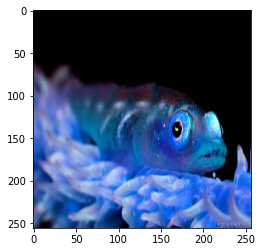

In [111]:
plt.imshow(fulldataX[1])
plt.show()

In [112]:
fulldataY[1]

array([10])

#### To Tensor

In [9]:
tensordataX = torch.FloatTensor(fulldataX)

tensordataY = torch.FloatTensor(fulldataY.astype(int))


tensordataX.shape, tensordataY.shape

(torch.Size([2254, 256, 256, 3]), torch.Size([2254, 1]))

<b>Permute Images so input channel is color for convolution</b>

In [10]:
tensordataX=tensordataX.permute(0,3,1,2)
tensordataX.shape

torch.Size([2254, 3, 256, 256])

### Train-Test split (80 : 20)

In [11]:
p=int(0.8*(tensordataX.shape[0]))

trainX=tensordataX[:p]
testX=tensordataX[p:]
trainY=tensordataY[:p]
testY=tensordataY[p:]

trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([1803, 3, 256, 256]),
 torch.Size([1803, 1]),
 torch.Size([451, 3, 256, 256]),
 torch.Size([451, 1]))

### Visualize Categories

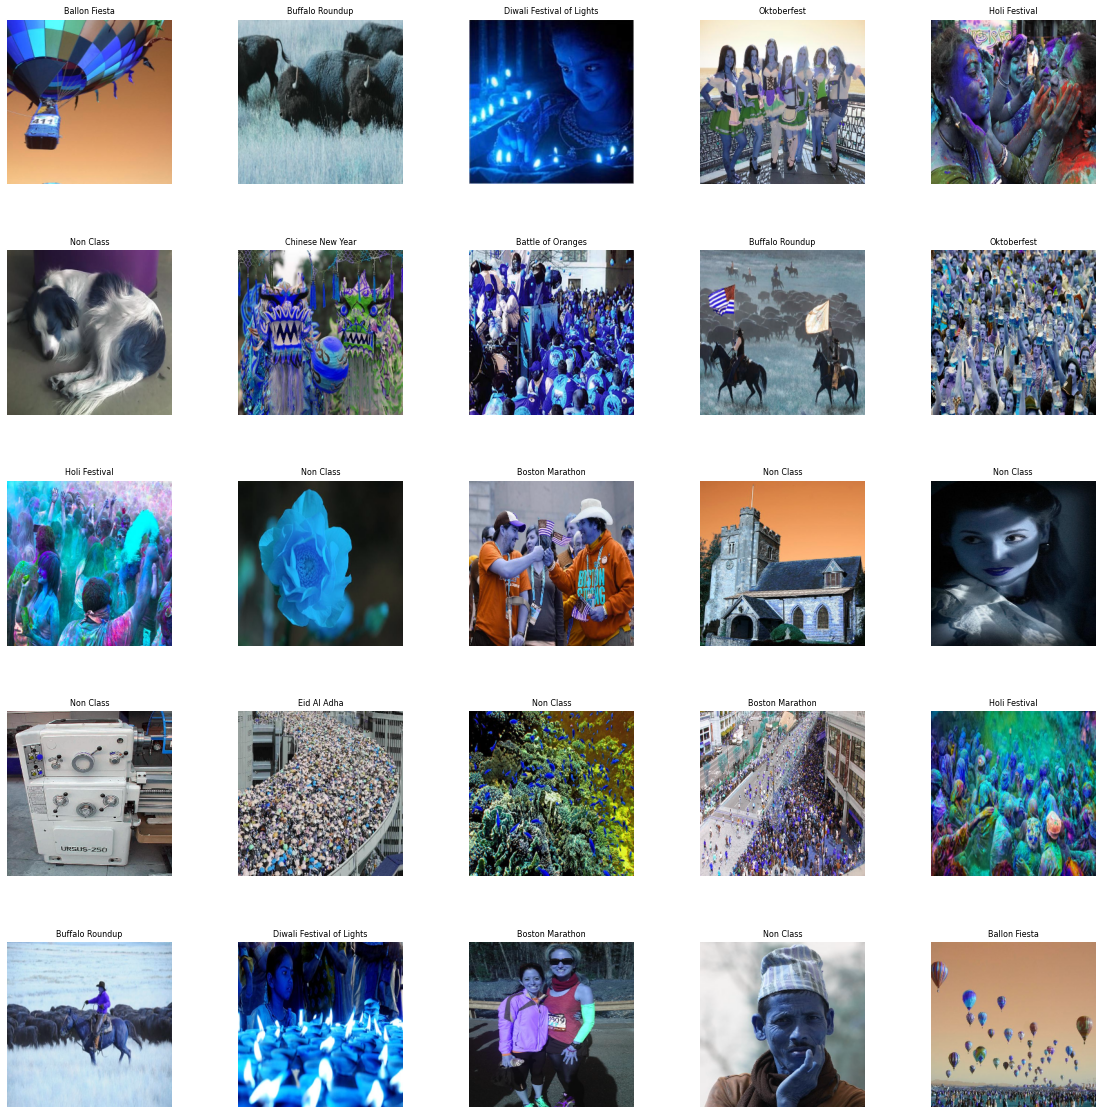

In [12]:
labels = ['Ballon Fiesta', 'Diwali Festival of Lights', 'Holi Festival', 'Frozen Dead guys', 'Buffalo Roundup','Battle of Oranges', 'Oktoberfest', 'Eid Al Adha', 'Chinese New Year', 'Boston Marathon', "Non Class"]


# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (20,20))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(trainX) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(fulldataX[index])
    label_index = int(trainY[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

### Vanilla CNN model

In [36]:
# CNN model
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        
        # define convolution layers
        """
        self.conv1 = nn.Conv2d(3, 96, kernel_size=(7,7), stride=2)
        self.conv2 = nn.Conv2d(96, 512, kernel_size=(3,3), stride=1)
        """
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5,5), stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5,5), stride=1)
        
        
        # figure out output conv flat length
        x = torch.randn(1,3,256,256)
        self._to_linear = None
        self.convs(x)
        
        # fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 500)
        self.fc2 = nn.Linear(500,250)
        self.fc3 = nn.Linear(250, 11)
        self.softmax = nn.Softmax(dim=1)

        
    def convs(self, x):
        # max pooling over 2x2 both Conv layers
        x=self.conv1(x)
        x=F.relu(x)
        x =F.max_pool2d(x, (2, 2))
        
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        
        
        #print(x.shape)
        # first pass, figure flat length
        if self._to_linear is None:
            print("x[0] : ",x[0].shape)
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x) # first two convolutional layers
        x = x.reshape(-1, self._to_linear) # flatten x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.sigmoid(self.fc3(x)) # Sigmoidal activation for output layer since two class problem
        x=F.log_softmax(self.fc3(x), dim=1)
        
        #x=self.softmax(self.fc3(x))
        #print("x:",x.shape)
        #print("x:",x)
        return x

In [37]:
vanillaCNN=Net()

x[0] :  torch.Size([16, 61, 61])


In [38]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device "%s" for training' % dev)

Using device "cuda" for training


In [39]:
vanillaCNN.to(dev)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=11, bias=True)
  (softmax): Softmax(dim=1)
)

In [40]:
#transform = torchvision.transforms.ToTensor()
img=trainX[:19].cuda()
print("image shape: ",img.shape)
print("reshaped img: ",img.view(-1,3,256,256).shape)

v=torch.randn(1,3,256,256).cuda()
print("v shape: ",v.shape)
r=vanillaCNN.forward(v)
simg=torch.squeeze(img.view(-1,3,256,256))
print("squezzed img: ",simg.shape)


im= torch.rand(10, 3, 256,256).cuda()
print("rand tensor shape: ",im.shape)
c=vanillaCNN.forward(im)

print("output: ",r)
print("rand img output: ",c.shape)

image shape:  torch.Size([19, 3, 256, 256])
reshaped img:  torch.Size([19, 3, 256, 256])
v shape:  torch.Size([1, 3, 256, 256])
squezzed img:  torch.Size([19, 3, 256, 256])
rand tensor shape:  torch.Size([10, 3, 256, 256])
output:  tensor([[-2.3624, -2.4524, -2.3318, -2.3268, -2.4437, -2.4041, -2.4000, -2.3851,
         -2.4190, -2.5072, -2.3591]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
rand img output:  torch.Size([10, 11])


In [41]:
b=vanillaCNN.forward(img)
print("batch result: ",b.shape)

batch result:  torch.Size([19, 11])


In [42]:
print("CNN Model:\n",vanillaCNN)

CNN Model:
 Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=11, bias=True)
  (softmax): Softmax(dim=1)
)


#### Train model

In [45]:
EPOCHS = 100
BATCH_SIZE = 250

In [46]:
min_loss = np.Inf #lowest loss will be the loaded model

loss_function = nn.CrossEntropyLoss().to(dev) 

optimizer = optim.Adam(vanillaCNN.parameters(),lr=0.00001)

epoch_num=[]
loss_arr=[]

enum=0
for epoch in range(EPOCHS):
    train_loss = 0
    vanillaCNN.train()
    for i in tqdm(range(0, len(trainX), BATCH_SIZE)): 
        #print(f"{i}:{i+BATCH_SIZE}")
        
        batch_X = trainX[i:i+BATCH_SIZE].to(dev)
        batch_y = trainY[i:i+BATCH_SIZE].to(dev)
        batch_y=batch_y.view(len(batch_y)).type(torch.LongTensor)
        
        vanillaCNN.zero_grad()
        #print("batch shape: ",batch_X.shape)
        batch_X=batch_X.cuda()
        batch_y=batch_y.cuda()

        outputs = vanillaCNN(batch_X)
        outputs.to(dev)
        #print("result shape: ",outputs.shape,batch_y.shape)
        
        #print(outputs.dtype)
        #print(batch_y.dtype)
        #print(outputs.shape," <=> ",batch_y.shape)
        
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    #update weights
        
        #print(loss.item())
        #print(loss.item()," - ",len(train_x))
        train_loss += loss.item()/len(trainX)
    #print("train loss: ",train_loss)
    if epoch % 5 == 0:
        print('Epoch: {}, Train Loss: {:.4f}, Current Min Loss: {:.4f}\n'.format(   #print training loss at each step
            epoch,
            train_loss,
            min_loss
        )) 
    if train_loss < min_loss:   
        min_loss = train_loss
    print(train_loss)
    epoch_num.append(enum)
    loss_arr.append(train_loss)
    enum+=1

100%|██████████| 8/8 [00:01<00:00,  5.19it/s]


Epoch: 0, Train Loss: 0.0126, Current Min Loss: inf

0.012562267957498019


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.008755705188660243


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.00942963060906908


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.009134867623721104


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.00872898650579299


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


Epoch: 5, Train Loss: 0.0085, Current Min Loss: 0.0087

0.008531275684147232


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.008384808790531675


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.008157868287461503


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.008000481280762159


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.00785841104789899


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


Epoch: 10, Train Loss: 0.0077, Current Min Loss: 0.0079

0.007656738947182315


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.007507019550748753


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.007328310742751136


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.007182596262732414


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.007033338165917928


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


Epoch: 15, Train Loss: 0.0069, Current Min Loss: 0.0070

0.0068782417891889045


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.006713646223858469


100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


0.006589954850148705


100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


0.006433912138111116


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.006294694663548694


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


Epoch: 20, Train Loss: 0.0061, Current Min Loss: 0.0063

0.00614506670718582


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.006024750549794565


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.005855159863986641


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.005751245066779756


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.00560178379184725


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


Epoch: 25, Train Loss: 0.0055, Current Min Loss: 0.0056

0.005504887830001145


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.005344372323269455


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.005254458799272264


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.005105447716271289


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.005024343811665649


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


Epoch: 30, Train Loss: 0.0049, Current Min Loss: 0.0050

0.004884787155929963


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0048038607429148955


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.004658130527005483


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0045778033175338856


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.004443103779175516


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


Epoch: 35, Train Loss: 0.0044, Current Min Loss: 0.0044

0.004361593105101413


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.004256840735359847


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.0041662652130201


100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


0.004055704514450056


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.003969846651809319


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


Epoch: 40, Train Loss: 0.0039, Current Min Loss: 0.0040

0.0038698955800092953


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0037873604696985756


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.003701891822412949


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.0035995934086247936


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0035169554530284962


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


Epoch: 45, Train Loss: 0.0034, Current Min Loss: 0.0035

0.0034292871530229225


100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


0.0033455770245804364


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0032545650874781593


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0031991370737188994


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0030899437447091437


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


Epoch: 50, Train Loss: 0.0030, Current Min Loss: 0.0031

0.0030450169420612565


100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


0.002974680593393276


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0028950293329908527


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0028445868361875607


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.0027516829557572213


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


Epoch: 55, Train Loss: 0.0027, Current Min Loss: 0.0028

0.002688062328202686


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0026112138415070553


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.002537580765887095


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.002487644817653261


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.0024026044444514193


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


Epoch: 60, Train Loss: 0.0023, Current Min Loss: 0.0024

0.0023463180229786828


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.0022941975917871696


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0022196087922179827


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0021708015966137714


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0021202915858971167


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


Epoch: 65, Train Loss: 0.0021, Current Min Loss: 0.0021

0.002063407378268123


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.002028742818553383


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.001970905515133376


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0019543954954832315


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0018650935182820013


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


Epoch: 70, Train Loss: 0.0019, Current Min Loss: 0.0019

0.001882787064519513


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.0017761791076385113


100%|██████████| 8/8 [00:01<00:00,  5.24it/s]


0.0018105936865309379


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.001692253908248855


100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


0.0017166224350151722


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


Epoch: 75, Train Loss: 0.0016, Current Min Loss: 0.0017

0.001601869530698953


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.0016319590702826485


100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


0.0015287996867399908


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.0015165588001839927


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.0014191273841604021


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


Epoch: 80, Train Loss: 0.0014, Current Min Loss: 0.0014

0.0013994071828909074


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0013398547686276935


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0012992726668872505


100%|██████████| 8/8 [00:01<00:00,  5.24it/s]


0.0012519148323546496


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0012189585837435867


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


Epoch: 85, Train Loss: 0.0012, Current Min Loss: 0.0012

0.0011816557746791732


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.001145787640406037


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.0011238171633785455


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.0010812939622470955


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0010665989482462307


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


Epoch: 90, Train Loss: 0.0010, Current Min Loss: 0.0011

0.0010273700566570823


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.0010110990093174868


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.0009749936073175484


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


0.000962024247785178


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0009269990745975253


100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


Epoch: 95, Train Loss: 0.0009, Current Min Loss: 0.0009

0.0009083131651579508


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.000885966803653334


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0008587022676146565


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


0.0008432682204828353


100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

0.0008165502173829198


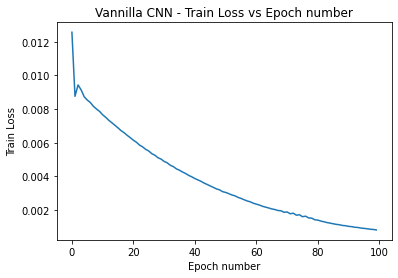

In [47]:
plt.plot(epoch_num, loss_arr)
plt.title('Vannilla CNN - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

#### Test

In [48]:
#def test(model,test_x,test_y):
def model_test(test_x,test_y, model, epoch_num=EPOCHS):
    model.train(False)
    correct = 0
    total = 0

    #print(test_y)
    with torch.no_grad():
        for i in tqdm(range(len(test_x))):
            real_class = test_y[i].to(dev)
            images=test_x[i].view(-1,3,256,256).to(dev)
            net_out = model(images) # returns a list, 

            predicted_class = torch.argmax(net_out,dim=1)
            #print(net_out," =>",predicted_class," : ",real_class)
            if predicted_class == real_class:
                correct += 1
                #print(net_out," =>",predicted_class," : ",real_class)
            total += 1
    print("Accuracy: ", round((correct/total)*100, 3)," % ")

In [49]:
vanillaCNN.train(False)
correct = 0
total = 0

#print(test_y)

with torch.no_grad():
    for i in tqdm(range(len(testX))):
        real_class = testY[i].to(dev)
        images=testX[i].view(-1,3,256,256).to(dev)
        net_out = vanillaCNN(images) # returns a list, 
        
        predicted_class = torch.argmax(net_out,dim=1)
        #print(net_out," =>",predicted_class," : ",real_class)
        #print(predicted_class.shape," : ",real_class.shape)
        if predicted_class == real_class:
            correct += 1
            #print(net_out," =>",predicted_class," : ",real_class)
        total += 1
print("Initial Model Accuracy: ", round((correct/total)*100, 3)," % ")

100%|██████████| 451/451 [00:00<00:00, 979.89it/s]

Initial Model Accuracy:  35.698  % 


### Model Train function

In [24]:
def model_train(model,trainX,trainY,testX,testY):
    trainX.to(dev)
    testX.to(dev)
    trainY.to(dev)
    testY.to(dev)
    model.to(dev)

    min_loss = np.Inf
    epoch_num=[]
    loss_arr=[]

    enum=0
    for epoch in range(EPOCHS):
        train_loss = 0
        model.train()

        for i in tqdm(range(0, len(trainX), BATCH_SIZE)): 
            #print(f"{i}:{i+BATCH_SIZE}")

            batch_X = trainX[i:i+BATCH_SIZE].to(dev)
            batch_y = trainY[i:i+BATCH_SIZE].to(dev)
            batch_y=batch_y.view(len(batch_y)).type(torch.LongTensor)

            # Clear accumulated gradients from previous iteration
            # before backpropagating. 
            model.zero_grad()
            batch_X=batch_X.cuda()
            batch_y=batch_y.cuda()
            #print(batch_X.shape)
            outputs = model(batch_X)
            outputs.to(dev)

            #print("result shape: ",outputs.shape,batch_y.shape)

            #print(outputs.dtype)
            #print(batch_y.dtype)

            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    #update weights

            #print(loss.item())
            #print(loss.item()," - ",len(train_x))
            train_loss += loss.item()/len(trainX)
        #print("train loss: ",train_loss)
        if epoch % 5 == 0:
            print('Epoch: {}, Train Loss: {:.4f}, Current Min Loss: {:.4f}\n'.format(   #print training loss at each step
                epoch,
                train_loss,
                min_loss
            )) 
        if train_loss < min_loss:   
            min_loss = train_loss
        epoch_num.append(enum)
        loss_arr.append(train_loss)
        enum+=1
    
    model_test(testX,testY, model, EPOCHS)

    return model,epoch_num,loss_arr

In [130]:
EPOCHS = 50
BATCH_SIZE = 100

In [131]:
trained_vanillaCNN, epoch_num,loss_arr = model_train(vanillaCNN, trainX,trainY,testX,testY)

100%|██████████| 19/19 [00:01<00:00, 16.03it/s]


Epoch: 0, Train Loss: 0.0004, Current Min Loss: inf



100%|██████████| 19/19 [00:01<00:00, 16.12it/s]


Epoch: 5, Train Loss: 0.0003, Current Min Loss: 0.0004



100%|██████████| 19/19 [00:01<00:00, 16.11it/s]


Epoch: 10, Train Loss: 0.0003, Current Min Loss: 0.0003



100%|██████████| 19/19 [00:01<00:00, 16.10it/s]


Epoch: 15, Train Loss: 0.0002, Current Min Loss: 0.0002



100%|██████████| 19/19 [00:01<00:00, 16.13it/s]


Epoch: 20, Train Loss: 0.0002, Current Min Loss: 0.0002



100%|██████████| 19/19 [00:01<00:00, 16.13it/s]


Epoch: 25, Train Loss: 0.0002, Current Min Loss: 0.0002



100%|██████████| 19/19 [00:01<00:00, 16.05it/s]


Epoch: 30, Train Loss: 0.0001, Current Min Loss: 0.0001



100%|██████████| 19/19 [00:01<00:00, 16.14it/s]


Epoch: 35, Train Loss: 0.0001, Current Min Loss: 0.0001



100%|██████████| 19/19 [00:01<00:00, 16.13it/s]


Epoch: 40, Train Loss: 0.0001, Current Min Loss: 0.0001



100%|██████████| 19/19 [00:01<00:00, 16.14it/s]


Epoch: 45, Train Loss: 0.0001, Current Min Loss: 0.0001



100%|██████████| 451/451 [00:00<00:00, 924.01it/s]

Accuracy:  39.468  % 


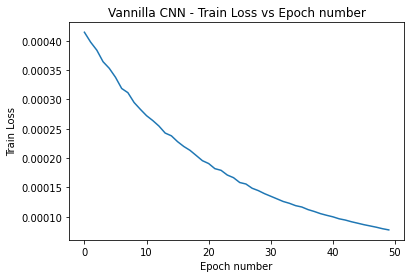

In [132]:
plt.plot(epoch_num, loss_arr)
plt.title('Vannilla CNN - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

### ResNet18

In [5]:
resNet = models.resnet18(pretrained=True)

num_ftrs = resNet.fc.in_features
print(num_ftrs)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/mkhanyisi/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



512


In [134]:
import gc
gc.collect()

53365

In [6]:
resNet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [135]:
resNet.fc = nn.Linear(num_ftrs, 11)
resNet.to(dev)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [136]:
EPOCHS = 100
BATCH_SIZE = 100

optimizer = optim.Adam(resNet.parameters(),lr=0.00001)
criterion = nn.CrossEntropyLoss().to(dev) 

In [137]:
trained_resNet, epoch_num,loss_arr = model_train(resNet, trainX,trainY,testX,testY)

100%|██████████| 19/19 [00:03<00:00,  6.01it/s]


Epoch: 0, Train Loss: 0.0261, Current Min Loss: inf



100%|██████████| 19/19 [00:03<00:00,  6.01it/s]


Epoch: 5, Train Loss: 0.0224, Current Min Loss: 0.0230



100%|██████████| 19/19 [00:03<00:00,  6.01it/s]


Epoch: 10, Train Loss: 0.0200, Current Min Loss: 0.0204



100%|██████████| 19/19 [00:03<00:00,  5.99it/s]


Epoch: 15, Train Loss: 0.0181, Current Min Loss: 0.0184



100%|██████████| 19/19 [00:03<00:00,  6.01it/s]


Epoch: 20, Train Loss: 0.0165, Current Min Loss: 0.0168



100%|██████████| 19/19 [00:03<00:00,  5.99it/s]


Epoch: 25, Train Loss: 0.0151, Current Min Loss: 0.0154



100%|██████████| 19/19 [00:03<00:00,  6.00it/s]


Epoch: 30, Train Loss: 0.0139, Current Min Loss: 0.0141



100%|██████████| 19/19 [00:03<00:00,  6.00it/s]


Epoch: 35, Train Loss: 0.0128, Current Min Loss: 0.0130



100%|██████████| 19/19 [00:03<00:00,  5.99it/s]


Epoch: 40, Train Loss: 0.0118, Current Min Loss: 0.0121



100%|██████████| 19/19 [00:03<00:00,  5.99it/s]


Epoch: 45, Train Loss: 0.0109, Current Min Loss: 0.0111



100%|██████████| 19/19 [00:03<00:00,  6.00it/s]


Epoch: 50, Train Loss: 0.0101, Current Min Loss: 0.0103



100%|██████████| 19/19 [00:03<00:00,  5.99it/s]


Epoch: 55, Train Loss: 0.0094, Current Min Loss: 0.0095



100%|██████████| 19/19 [00:03<00:00,  6.00it/s]


Epoch: 60, Train Loss: 0.0086, Current Min Loss: 0.0088



100%|██████████| 19/19 [00:03<00:00,  5.98it/s]


Epoch: 65, Train Loss: 0.0079, Current Min Loss: 0.0080



100%|██████████| 19/19 [00:03<00:00,  6.00it/s]


Epoch: 70, Train Loss: 0.0073, Current Min Loss: 0.0074



100%|██████████| 19/19 [00:03<00:00,  5.99it/s]


Epoch: 75, Train Loss: 0.0066, Current Min Loss: 0.0067



100%|██████████| 19/19 [00:03<00:00,  6.00it/s]


Epoch: 80, Train Loss: 0.0060, Current Min Loss: 0.0061



100%|██████████| 19/19 [00:03<00:00,  5.99it/s]


Epoch: 85, Train Loss: 0.0053, Current Min Loss: 0.0054



100%|██████████| 19/19 [00:03<00:00,  5.98it/s]


Epoch: 90, Train Loss: 0.0047, Current Min Loss: 0.0048



100%|██████████| 19/19 [00:03<00:00,  6.00it/s]


Epoch: 95, Train Loss: 0.0043, Current Min Loss: 0.0043



100%|██████████| 451/451 [00:01<00:00, 277.14it/s]

Accuracy:  38.581  % 


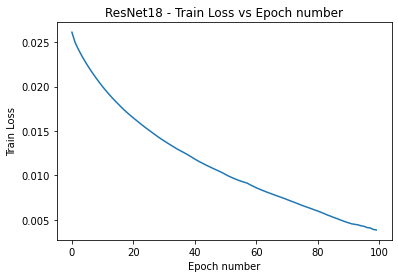

In [138]:
plt.plot(epoch_num, loss_arr)
plt.title('ResNet18 - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

### AlexNet

In [139]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=11):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 12 * 12, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        #print("conv output shape: ",x.shape)
        x = x.reshape(x.size(0), 256 * 12 * 12)
        x = F.log_softmax(self.classifier(x),dim=1)
        return x

In [140]:
alexNet=AlexNet(11)

In [141]:
alexNet.to(dev)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=36864, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
  

In [142]:
EPOCHS = 100
BATCH_SIZE = 100

optimizer = optim.Adam(alexNet.parameters(),lr=0.00001)

In [143]:
print(img.shape)
b=alexNet(img)
print("batch result: ",b.shape)
b

torch.Size([19, 3, 256, 256])
batch result:  torch.Size([19, 11])


tensor([[-2.0998, -2.2891, -2.5816, -1.6962, -2.7551, -2.6610, -2.5574, -2.5696,
         -2.6816, -2.4222, -2.6256],
        [-2.2664, -2.6689, -2.6432, -2.0229, -2.3022, -2.3857, -2.5585, -2.4235,
         -2.7536, -2.2033, -2.3930],
        [-2.5192, -2.3941, -2.8670, -1.9406, -2.6559, -2.3264, -2.9848, -2.1910,
         -2.8381, -2.0670, -2.1856],
        [-3.1175, -2.5506, -2.4510, -1.4837, -2.2324, -2.4098, -2.5857, -2.5077,
         -3.7856, -2.4881, -2.2535],
        [-2.1541, -2.4156, -2.2889, -2.1809, -2.1653, -2.8687, -2.2969, -2.1335,
         -3.2015, -2.8111, -2.4187],
        [-2.2818, -2.4324, -2.5506, -2.1800, -2.2261, -2.4967, -2.3683, -2.5217,
         -2.7945, -2.3807, -2.2917],
        [-2.4607, -2.3481, -2.9756, -2.4594, -1.9644, -2.5955, -2.4770, -2.1432,
         -3.1819, -2.1062, -2.2706],
        [-3.0064, -2.6562, -2.7702, -2.2452, -2.0729, -2.2484, -2.3251, -2.0944,
         -2.6470, -2.8124, -2.0516],
        [-2.6357, -2.7019, -2.9582, -2.1791, -2.1399, -2

In [144]:
trained_alexNet , epoch_num,loss_arr= model_train(alexNet, trainX,trainY,testX,testY)

100%|██████████| 19/19 [00:02<00:00,  6.51it/s]


Epoch: 0, Train Loss: 0.0489, Current Min Loss: inf



100%|██████████| 19/19 [00:02<00:00,  6.51it/s]


Epoch: 5, Train Loss: 0.0241, Current Min Loss: 0.0245



100%|██████████| 19/19 [00:02<00:00,  6.49it/s]


Epoch: 10, Train Loss: 0.0221, Current Min Loss: 0.0225



100%|██████████| 19/19 [00:02<00:00,  6.51it/s]


Epoch: 15, Train Loss: 0.0206, Current Min Loss: 0.0214



100%|██████████| 19/19 [00:02<00:00,  6.50it/s]


Epoch: 20, Train Loss: 0.0186, Current Min Loss: 0.0189



100%|██████████| 19/19 [00:02<00:00,  6.50it/s]


Epoch: 25, Train Loss: 0.0171, Current Min Loss: 0.0179



100%|██████████| 19/19 [00:02<00:00,  6.50it/s]


Epoch: 30, Train Loss: 0.0158, Current Min Loss: 0.0163



100%|██████████| 19/19 [00:02<00:00,  6.50it/s]


Epoch: 35, Train Loss: 0.0145, Current Min Loss: 0.0143



100%|██████████| 19/19 [00:02<00:00,  6.49it/s]


Epoch: 40, Train Loss: 0.0132, Current Min Loss: 0.0124



100%|██████████| 19/19 [00:02<00:00,  6.50it/s]


Epoch: 45, Train Loss: 0.0108, Current Min Loss: 0.0103



100%|██████████| 19/19 [00:02<00:00,  6.50it/s]


Epoch: 50, Train Loss: 0.0080, Current Min Loss: 0.0085



100%|██████████| 19/19 [00:02<00:00,  6.48it/s]


Epoch: 55, Train Loss: 0.0056, Current Min Loss: 0.0063



100%|██████████| 19/19 [00:02<00:00,  6.51it/s]


Epoch: 60, Train Loss: 0.0038, Current Min Loss: 0.0044



100%|██████████| 19/19 [00:02<00:00,  6.50it/s]


Epoch: 65, Train Loss: 0.0023, Current Min Loss: 0.0022



100%|██████████| 19/19 [00:02<00:00,  6.50it/s]


Epoch: 70, Train Loss: 0.0010, Current Min Loss: 0.0011



100%|██████████| 19/19 [00:02<00:00,  6.50it/s]


Epoch: 75, Train Loss: 0.0006, Current Min Loss: 0.0007



100%|██████████| 19/19 [00:02<00:00,  6.49it/s]


Epoch: 80, Train Loss: 0.0003, Current Min Loss: 0.0003



100%|██████████| 19/19 [00:02<00:00,  6.49it/s]


Epoch: 85, Train Loss: 0.0002, Current Min Loss: 0.0002



100%|██████████| 19/19 [00:02<00:00,  6.48it/s]


Epoch: 90, Train Loss: 0.0002, Current Min Loss: 0.0002



100%|██████████| 19/19 [00:02<00:00,  6.49it/s]


Epoch: 95, Train Loss: 0.0001, Current Min Loss: 0.0001



100%|██████████| 451/451 [00:00<00:00, 493.26it/s]

Accuracy:  33.703  % 


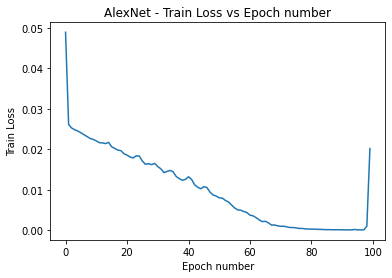

In [145]:
plt.plot(epoch_num, loss_arr)
plt.title('AlexNet - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

### Pretrained on ImageNet AlexNet

In [146]:
pretrained_AlexNet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [147]:
#pretrained_AlexNet

In [148]:
num_ftrs = pretrained_AlexNet.classifier[6].in_features
num_ftrs

4096

In [149]:
pretrained_AlexNet.classifier[6]= nn.Linear(num_ftrs, 11)
pretrained_AlexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [150]:
optimizer = optim.Adam(pretrained_AlexNet.parameters(),lr=0.00001)

In [151]:
EPOCHS = 100
BATCH_SIZE = 200

In [152]:
retrained_AlexNet, epoch_num,loss_arr = model_train(pretrained_AlexNet, trainX,trainY,testX,testY)

100%|██████████| 10/10 [00:01<00:00,  7.38it/s]


Epoch: 0, Train Loss: 0.1330, Current Min Loss: inf



100%|██████████| 10/10 [00:01<00:00,  7.38it/s]


Epoch: 5, Train Loss: 0.0289, Current Min Loss: 0.0325



100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


Epoch: 10, Train Loss: 0.0172, Current Min Loss: 0.0179



100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


Epoch: 15, Train Loss: 0.0111, Current Min Loss: 0.0127



100%|██████████| 10/10 [00:01<00:00,  7.35it/s]


Epoch: 20, Train Loss: 0.0089, Current Min Loss: 0.0095



100%|██████████| 10/10 [00:01<00:00,  7.35it/s]


Epoch: 25, Train Loss: 0.0074, Current Min Loss: 0.0077



100%|██████████| 10/10 [00:01<00:00,  7.38it/s]


Epoch: 30, Train Loss: 0.0063, Current Min Loss: 0.0063



100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


Epoch: 35, Train Loss: 0.0055, Current Min Loss: 0.0056



100%|██████████| 10/10 [00:01<00:00,  7.37it/s]


Epoch: 40, Train Loss: 0.0045, Current Min Loss: 0.0047



100%|██████████| 10/10 [00:01<00:00,  7.37it/s]


Epoch: 45, Train Loss: 0.0038, Current Min Loss: 0.0040



100%|██████████| 10/10 [00:01<00:00,  7.38it/s]


Epoch: 50, Train Loss: 0.0034, Current Min Loss: 0.0033



100%|██████████| 10/10 [00:01<00:00,  7.37it/s]


Epoch: 55, Train Loss: 0.0030, Current Min Loss: 0.0030



100%|██████████| 10/10 [00:01<00:00,  7.35it/s]


Epoch: 60, Train Loss: 0.0025, Current Min Loss: 0.0025



100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


Epoch: 65, Train Loss: 0.0021, Current Min Loss: 0.0020



100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


Epoch: 70, Train Loss: 0.0020, Current Min Loss: 0.0020



100%|██████████| 10/10 [00:01<00:00,  7.38it/s]


Epoch: 75, Train Loss: 0.0016, Current Min Loss: 0.0017



100%|██████████| 10/10 [00:01<00:00,  7.35it/s]


Epoch: 80, Train Loss: 0.0013, Current Min Loss: 0.0014



100%|██████████| 10/10 [00:01<00:00,  7.34it/s]


Epoch: 85, Train Loss: 0.0012, Current Min Loss: 0.0012



100%|██████████| 10/10 [00:01<00:00,  7.37it/s]


Epoch: 90, Train Loss: 0.0010, Current Min Loss: 0.0011



100%|██████████| 10/10 [00:01<00:00,  7.37it/s]


Epoch: 95, Train Loss: 0.0010, Current Min Loss: 0.0009



100%|██████████| 451/451 [00:00<00:00, 643.58it/s]

Accuracy:  58.537  % 


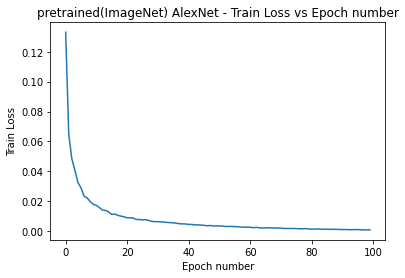

In [153]:
plt.plot(epoch_num, loss_arr)
plt.title('pretrained(ImageNet) AlexNet - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

### VGG16

In [154]:
vgg16 = models.vgg16()

In [155]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [156]:
num_ftrs = vgg16.classifier[0].in_features
num_ftrs

25088

In [157]:
vgg16.classifier=nn.Sequential(nn.Linear(num_ftrs,1000),  nn.ReLU(inplace=True),nn.Dropout(0.5,inplace=True),nn.Linear(1000, out_features=11, bias=True))

In [158]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [159]:
optimizer = optim.Adam(vgg16.parameters(),lr=0.00001)

In [160]:
EPOCHS = 40
BATCH_SIZE = 2

In [161]:
gc.collect()

7359

In [162]:
#trained_vgg16, epoch_num,loss_arr = model_train(vgg16, trainX,trainY,testX,testY)

Tried reducing BATCH_SIZE and I still get this error, so model will be skipped :(

### GoogLeNet

In [3]:
googLeNet=torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /Users/mkhanyisi/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /Users/mkhanyisi/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [4]:
googLeNet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [165]:
num_ftrs = googLeNet.fc.in_features
num_ftrs

1024

In [166]:
googLeNet.fc= nn.Linear(num_ftrs, 11)
#googLeNet

In [167]:
optimizer = optim.Adam(googLeNet.parameters(),lr=0.00001)

In [168]:
BATCH_SIZE = 2
EPOCHS = 140

In [169]:
trained_googLeNet, epoch_num,loss_arr = model_train(googLeNet, trainX,trainY,testX,testY)

  0%|          | 0/902 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|██████████| 902/902 [00:39<00:00, 22.76it/s]


Epoch: 0, Train Loss: 1.2213, Current Min Loss: inf



100%|██████████| 902/902 [00:40<00:00, 22.54it/s]


Epoch: 5, Train Loss: 1.1039, Current Min Loss: 1.0868



100%|██████████| 902/902 [00:39<00:00, 22.85it/s]


Epoch: 10, Train Loss: 1.0435, Current Min Loss: 1.0271



100%|██████████| 902/902 [00:39<00:00, 23.04it/s]


Epoch: 15, Train Loss: 0.9039, Current Min Loss: 0.9516



100%|██████████| 902/902 [00:39<00:00, 22.88it/s]


Epoch: 20, Train Loss: 0.7144, Current Min Loss: 0.7644



100%|██████████| 902/902 [00:39<00:00, 23.02it/s]


Epoch: 25, Train Loss: 0.5694, Current Min Loss: 0.6038



100%|██████████| 902/902 [00:39<00:00, 23.03it/s]


Epoch: 30, Train Loss: 0.4476, Current Min Loss: 0.4705



100%|██████████| 902/902 [00:38<00:00, 23.53it/s]


Epoch: 35, Train Loss: 0.3545, Current Min Loss: 0.3757



100%|██████████| 902/902 [00:39<00:00, 23.07it/s]


Epoch: 40, Train Loss: 0.2480, Current Min Loss: 0.2682



100%|██████████| 902/902 [00:38<00:00, 23.30it/s]


Epoch: 45, Train Loss: 0.1741, Current Min Loss: 0.1867



100%|██████████| 902/902 [00:38<00:00, 23.25it/s]


Epoch: 50, Train Loss: 0.1157, Current Min Loss: 0.1249



100%|██████████| 902/902 [00:38<00:00, 23.51it/s]


Epoch: 55, Train Loss: 0.0829, Current Min Loss: 0.0917



100%|██████████| 902/902 [00:40<00:00, 22.48it/s]


Epoch: 60, Train Loss: 0.0631, Current Min Loss: 0.0629



100%|██████████| 902/902 [00:38<00:00, 23.39it/s]


Epoch: 65, Train Loss: 0.0450, Current Min Loss: 0.0458



100%|██████████| 902/902 [00:38<00:00, 23.60it/s]


Epoch: 70, Train Loss: 0.0413, Current Min Loss: 0.0415



100%|██████████| 902/902 [00:38<00:00, 23.41it/s]


Epoch: 75, Train Loss: 0.0210, Current Min Loss: 0.0238



100%|██████████| 902/902 [00:38<00:00, 23.39it/s]


Epoch: 80, Train Loss: 0.0110, Current Min Loss: 0.0118



100%|██████████| 902/902 [00:39<00:00, 22.76it/s]


Epoch: 85, Train Loss: 0.0037, Current Min Loss: 0.0035



100%|██████████| 902/902 [00:38<00:00, 23.26it/s]


Epoch: 90, Train Loss: 0.0015, Current Min Loss: 0.0017



100%|██████████| 902/902 [00:38<00:00, 23.39it/s]


Epoch: 95, Train Loss: 0.0012, Current Min Loss: 0.0015



100%|██████████| 902/902 [00:38<00:00, 23.24it/s]


Epoch: 100, Train Loss: 0.0005, Current Min Loss: 0.0006



100%|██████████| 902/902 [00:38<00:00, 23.51it/s]


Epoch: 105, Train Loss: 0.0012, Current Min Loss: 0.0003



100%|██████████| 902/902 [00:38<00:00, 23.56it/s]


Epoch: 110, Train Loss: 0.0004, Current Min Loss: 0.0003



100%|██████████| 902/902 [00:38<00:00, 23.46it/s]


Epoch: 115, Train Loss: 0.0002, Current Min Loss: 0.0002



100%|██████████| 902/902 [00:38<00:00, 23.65it/s]


Epoch: 120, Train Loss: 0.0001, Current Min Loss: 0.0001



100%|██████████| 902/902 [00:40<00:00, 22.47it/s]


Epoch: 125, Train Loss: 0.0038, Current Min Loss: 0.0001



100%|██████████| 902/902 [00:38<00:00, 23.62it/s]


Epoch: 130, Train Loss: 0.0001, Current Min Loss: 0.0001



100%|██████████| 902/902 [00:38<00:00, 23.52it/s]


Epoch: 135, Train Loss: 0.0000, Current Min Loss: 0.0001



100%|██████████| 451/451 [00:04<00:00, 100.34it/s]

Accuracy:  0.222  % 


In [170]:
model_test(testX,testY, trained_googLeNet, epoch_num=EPOCHS)

  0%|          | 0/451 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|██████████| 451/451 [00:04<00:00, 98.54it/s]

Accuracy:  0.222  % 


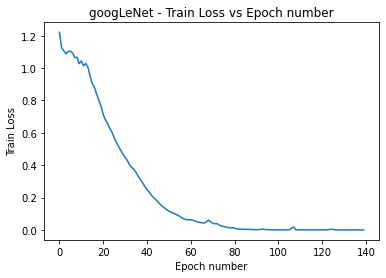

In [171]:
plt.plot(epoch_num, loss_arr)
plt.title('googLeNet - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

### ResNet34

In [172]:
#resNext50 = models.resnext50_32x4d(pretrained=True)
resNet34=models.resnet34(pretrained=True)

In [173]:
resNet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [174]:
num_ftrs = resNet34.fc.in_features
num_ftrs

512

In [175]:
resNet34.fc= nn.Linear(num_ftrs, 11)

In [176]:
optimizer = optim.Adam(resNet34.parameters(),lr=0.00001)

In [177]:
BATCH_SIZE = 100
EPOCHS = 100

In [178]:
trained_resNet34, epoch_num,loss_arr = model_train(resNet34, trainX,trainY,testX,testY)

100%|██████████| 19/19 [00:05<00:00,  3.43it/s]


Epoch: 0, Train Loss: 0.0289, Current Min Loss: inf



100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


Epoch: 5, Train Loss: 0.0227, Current Min Loss: 0.0236



100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


Epoch: 10, Train Loss: 0.0189, Current Min Loss: 0.0195



100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


Epoch: 15, Train Loss: 0.0159, Current Min Loss: 0.0164



100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch: 20, Train Loss: 0.0133, Current Min Loss: 0.0138



100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch: 25, Train Loss: 0.0110, Current Min Loss: 0.0115



100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch: 30, Train Loss: 0.0093, Current Min Loss: 0.0096



100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch: 35, Train Loss: 0.0078, Current Min Loss: 0.0080



100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


Epoch: 40, Train Loss: 0.0065, Current Min Loss: 0.0067



100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch: 45, Train Loss: 0.0055, Current Min Loss: 0.0056



100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch: 50, Train Loss: 0.0048, Current Min Loss: 0.0050



100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch: 55, Train Loss: 0.0042, Current Min Loss: 0.0043



100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch: 60, Train Loss: 0.0038, Current Min Loss: 0.0039



100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


Epoch: 65, Train Loss: 0.0034, Current Min Loss: 0.0034



100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


Epoch: 70, Train Loss: 0.0031, Current Min Loss: 0.0031



100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch: 75, Train Loss: 0.0028, Current Min Loss: 0.0029



100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


Epoch: 80, Train Loss: 0.0027, Current Min Loss: 0.0027



100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch: 85, Train Loss: 0.0024, Current Min Loss: 0.0025



100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch: 90, Train Loss: 0.0023, Current Min Loss: 0.0023



100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch: 95, Train Loss: 0.0022, Current Min Loss: 0.0022



100%|██████████| 451/451 [00:02<00:00, 163.65it/s]

Accuracy:  48.559  % 


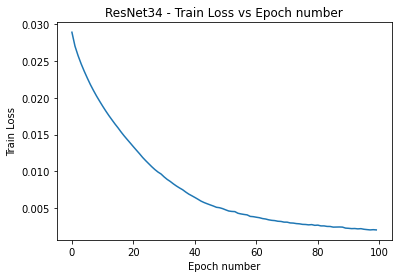

In [179]:
plt.plot(epoch_num, loss_arr)
plt.title('ResNet34 - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

In [180]:
len(loss_arr)

100

### ResNext 50 32x4d

In [181]:
resNext50=models.resnext50_32x4d(pretrained=True)

In [182]:
resNext50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [183]:
num_ftrs = resNext50.fc.in_features
num_ftrs

2048

In [184]:
resNext50.fc = nn.Linear(num_ftrs, 11)

In [185]:
optimizer = optim.Adam(resNext50.parameters(),lr=0.00001)

In [186]:
BATCH_SIZE = 5
EPOCHS = 100

In [187]:

gc.collect()

5189

In [188]:
trained_resNext50, epoch_num,loss_arr = model_train(resNext50, trainX,trainY,testX,testY)

100%|██████████| 361/361 [00:31<00:00, 11.54it/s]


Epoch: 0, Train Loss: 0.5186, Current Min Loss: inf



100%|██████████| 361/361 [00:31<00:00, 11.64it/s]


Epoch: 5, Train Loss: 0.3947, Current Min Loss: 0.4083



100%|██████████| 361/361 [00:30<00:00, 11.67it/s]


Epoch: 10, Train Loss: 0.3024, Current Min Loss: 0.3252



100%|██████████| 361/361 [00:31<00:00, 11.64it/s]


Epoch: 15, Train Loss: 0.1621, Current Min Loss: 0.1901



100%|██████████| 361/361 [00:31<00:00, 11.61it/s]


Epoch: 20, Train Loss: 0.0753, Current Min Loss: 0.0892



100%|██████████| 361/361 [00:30<00:00, 11.67it/s]


Epoch: 25, Train Loss: 0.0418, Current Min Loss: 0.0474



100%|██████████| 361/361 [00:31<00:00, 11.63it/s]


Epoch: 30, Train Loss: 0.0228, Current Min Loss: 0.0249



100%|██████████| 361/361 [00:31<00:00, 11.64it/s]


Epoch: 35, Train Loss: 0.0118, Current Min Loss: 0.0139



100%|██████████| 361/361 [00:31<00:00, 11.58it/s]


Epoch: 40, Train Loss: 0.0066, Current Min Loss: 0.0075



100%|██████████| 361/361 [00:31<00:00, 11.60it/s]


Epoch: 45, Train Loss: 0.0041, Current Min Loss: 0.0042



100%|██████████| 361/361 [00:31<00:00, 11.61it/s]


Epoch: 50, Train Loss: 0.0018, Current Min Loss: 0.0020



100%|██████████| 361/361 [00:31<00:00, 11.63it/s]


Epoch: 55, Train Loss: 0.0010, Current Min Loss: 0.0011



100%|██████████| 361/361 [00:31<00:00, 11.63it/s]


Epoch: 60, Train Loss: 0.0006, Current Min Loss: 0.0008



100%|██████████| 361/361 [00:31<00:00, 11.58it/s]


Epoch: 65, Train Loss: 0.0003, Current Min Loss: 0.0003



100%|██████████| 361/361 [00:31<00:00, 11.57it/s]


Epoch: 70, Train Loss: 0.0004, Current Min Loss: 0.0002



100%|██████████| 361/361 [00:30<00:00, 11.66it/s]


Epoch: 75, Train Loss: 0.0001, Current Min Loss: 0.0002



100%|██████████| 361/361 [00:31<00:00, 11.58it/s]


Epoch: 80, Train Loss: 0.0001, Current Min Loss: 0.0001



100%|██████████| 361/361 [00:31<00:00, 11.63it/s]


Epoch: 85, Train Loss: 0.0001, Current Min Loss: 0.0001



100%|██████████| 361/361 [00:31<00:00, 11.63it/s]


Epoch: 90, Train Loss: 0.0000, Current Min Loss: 0.0000



100%|██████████| 361/361 [00:31<00:00, 11.59it/s]


Epoch: 95, Train Loss: 0.0000, Current Min Loss: 0.0000



100%|██████████| 451/451 [00:04<00:00, 105.13it/s]

Accuracy:  0.222  % 


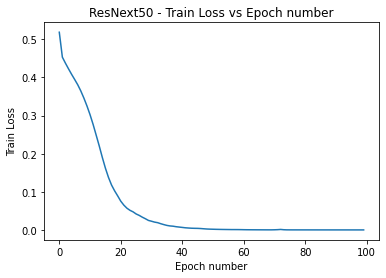

In [189]:
plt.plot(epoch_num, loss_arr)
plt.title('ResNext50 - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

### VGGNet - VGG 11-layer model (configuration “A”) 

In [29]:
vgg11= models.vgg11(pretrained=True)

In [30]:
vgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [31]:
num_ftrs = vgg11.classifier[0].in_features
num_ftrs

25088

In [32]:
vgg11.classifier=nn.Sequential(nn.Linear(num_ftrs,1000),  nn.ReLU(inplace=True),nn.Dropout(0.5,inplace=True),nn.Linear(1000, out_features=11, bias=True))

In [33]:
optimizer = optim.Adam(vgg11.parameters(),lr=0.00001)
loss_function = nn.CrossEntropyLoss().to(dev) 

In [56]:
EPOCHS = 50
BATCH_SIZE = 1

In [57]:
trained_vgg11, epoch_num,loss_arr = model_train(vgg11, trainX,trainY,testX,testY)

RuntimeError: ignored

#### Model training could not be completed with resources

3397

### Resources

- https://competitions.codalab.org/competitions/4081#participate-get-data
- 


- https://blog.keras.io/running-jupyter-notebooks-on-gpu-on-aws-a-starter-guide.html

##### 